In [1]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera

from IPython.display import HTML



import warnings

import numpy as np
import pandas as pd
import copy
import random

from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl
from tslib.tests import testdata

warnings.filterwarnings(action='once')


In [2]:
from filter_data import *
        
        
#global settings for graphs        
cc = (cycler(color=list('rgbcmyk')) *
      cycler(linestyle=['-', '--', '-.',':']))
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cc)

In [3]:
from load_and_clean import *

us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')

global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')

mobility_data_apple, mobility_data_google = load_clean('mobility')

sd_data = load_clean('IHME intervention')

#global_country_aggr = global_covid.groupby('Country/Region').sum()


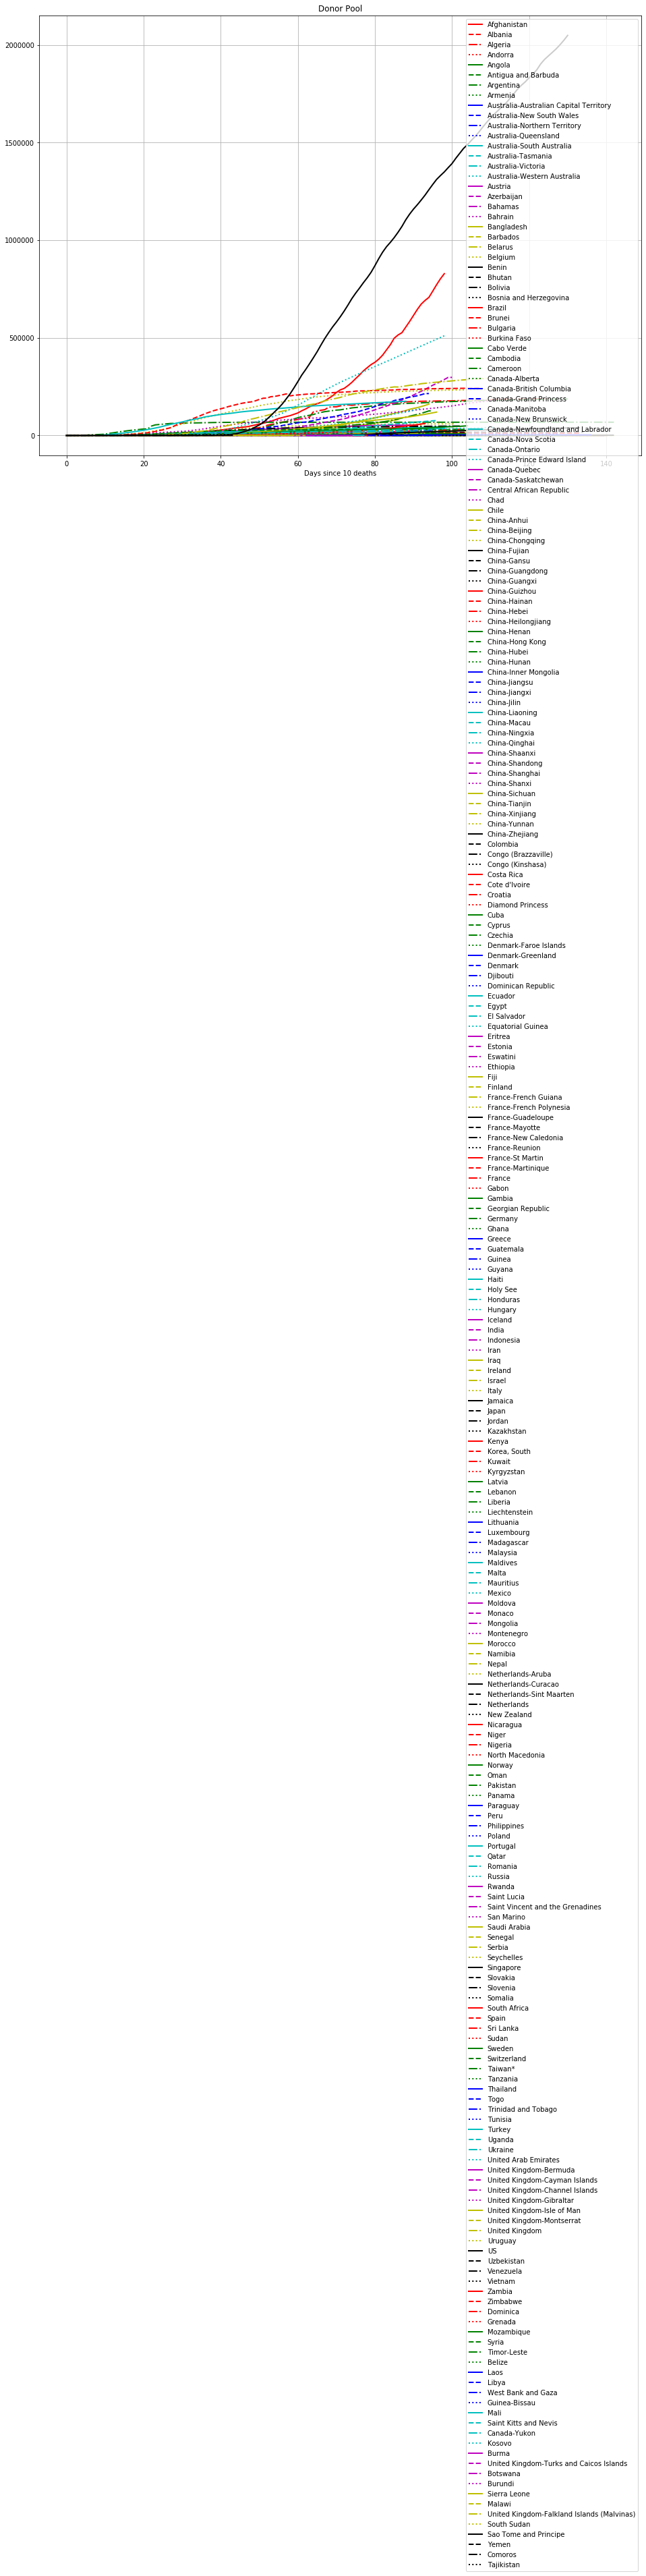

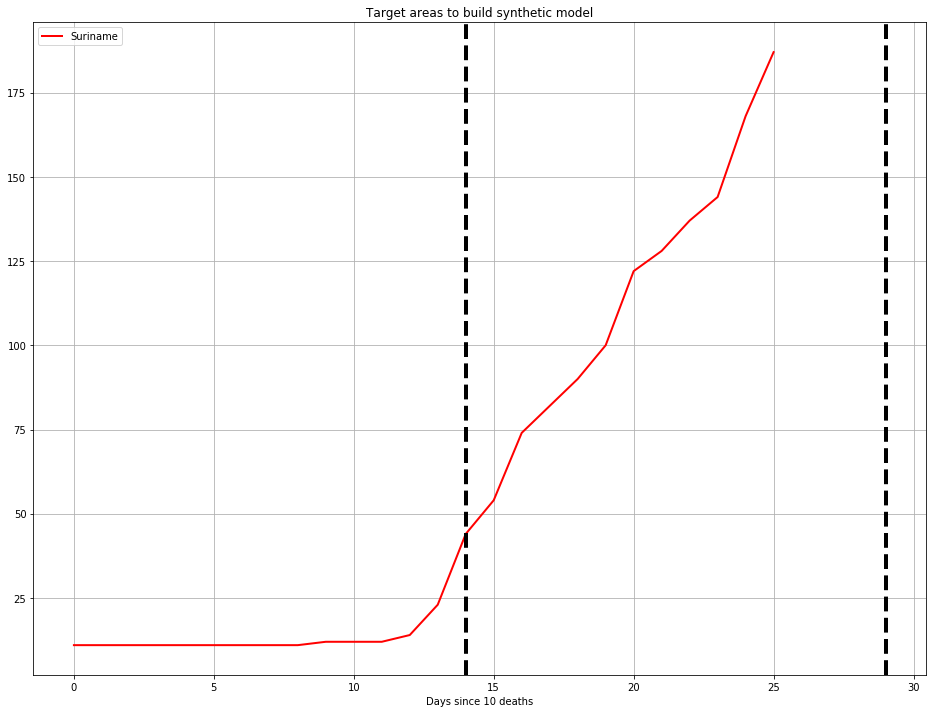

In [4]:
global_cases_filtered = create_filtered_data(global_cases, 10 )

sizes = global_cases_filtered.apply(pd.Series.last_valid_index)
  
low_thresh=15
threshold=30
donorlpool = list(sizes[sizes>threshold].index)

global_cases_filtered[donorlpool].plot(figsize=(16,12), grid=True, title='Donor Pool', linewidth=2)
plt.xlabel('Days since 10 deaths')
plt.show()

prediction_states = list(sizes[(sizes>low_thresh) & (sizes<threshold)].index)
global_cases_filtered[prediction_states].plot(figsize=(16,12), grid=True, title='Target areas to build synthetic model', linewidth=2)
plt.xlabel('Days since 10 deaths')
plt.axvline(x=low_thresh-1, color='k', linestyle='--', linewidth=4)
plt.axvline(x=threshold-1, color='k', linestyle='--', linewidth=4)


plt.show()


In [5]:
rolling_average_duration = 3

daily_global = create_filtered_data(global_cases,5).diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
daily_us = create_filtered_data(uscases,5).diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
daily_uscountines = create_filtered_data(uscounties_deaths,5).diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]


In [6]:
print(sd_data.columns)
intervention_tried = sd_data.columns[7]
print(intervention_tried)
educational_distancing = sd_data[['country','name',intervention_tried]]
educational_distancing[intervention_tried] = educational_distancing[intervention_tried].str.replace(".","-")


Index(['name', 'country', 'admin1', 'Mass gathering restrictions',
       'Stay at Home Order', 'Educational facilities closed',
       'Initial business closures', 'Non-essential services closed',
       'Travel severely limited', 'Source Mass gathering restrictions',
       'Source Stay at Home Order', 'Source Educational facilities closed',
       'Source Initial business closure',
       'Source Non-essential services closed',
       'Source Travel severely limited', 'last date'],
      dtype='object')
Non-essential services closed


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [7]:
for place in educational_distancing.name:
#or place in ['Belgium', 'Finland']:
    split_values = educational_distancing[educational_distancing.name == place][intervention_tried].str.split("-").values
    #print(split_values)
    #print(place, split_values, split_values.shape)
    if(split_values):
        if(len(split_values[0])>1):
        #print(split_values[0])
        #print(place)
            educational_distancing.loc[educational_distancing.name == place, "date"] = split_values[0][2]+"-"+split_values[0][1]+"-"+split_values[0][0]
        else:
            print(place)
            print(educational_distancing[educational_distancing.name == place])

Hamburg
   country     name Non-essential services closed date
6  Germany  Hamburg               not implemented  NaN
Hesse
   country   name Non-essential services closed date
7  Germany  Hesse               not implemented  NaN
Saarland
    country      name Non-essential services closed date
12  Germany  Saarland               not implemented  NaN
Thuringia
    country       name Non-essential services closed date
16  Germany  Thuringia               not implemented  NaN
Arizona
   country     name Non-essential services closed date
40     USA  Arizona               not implemented  NaN
Arkansas
   country      name Non-essential services closed date
41     USA  Arkansas               not implemented  NaN
Florida
   country     name Non-essential services closed date
48     USA  Florida               not implemented  NaN
Georgia
   country     name Non-essential services closed date
49     USA  Georgia               not implemented  NaN
Iowa
   country  name Non-essential services c

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

Oregon
   country    name Non-essential services closed date
77     USA  Oregon               not implemented  NaN
Rhode Island
   country          name Non-essential services closed date
79     USA  Rhode Island               not implemented  NaN
South Carolina
   country            name Non-essential services closed date
80     USA  South Carolina               not implemented  NaN
South Dakota
   country          name Non-essential services closed date
81     USA  South Dakota               not implemented  NaN
Texas
   country   name Non-essential services closed date
83     USA  Texas               not implemented  NaN
Utah
   country  name Non-essential services closed date
84     USA  Utah               not implemented  NaN
Wyoming
   country     name Non-essential services closed date
95     USA  Wyoming               not implemented  NaN
Sweden
    country    name Non-essential services closed date
121  Sweden  Sweden               not implemented  NaN
Netherlands
         cou

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove

In [8]:
#us_school_closures
#educational_distancing[educational_distancing.country=="Italy"]
#educational_distancing.append({'country':'Spain', 'name':'Spain', 'date':'2020-03-14'}, ignore_index=True)

In [9]:
# some country names end with '-'
global_cases.columns = global_cases.columns.str.rstrip('-')
print(global_cases.columns)

newdf_global = pd.DataFrame()
for i in range(0, 20):
    for state in global_cases.columns:
        #state = state.rstrip('-')
        intervention_date = educational_distancing[educational_distancing.name == state].date.values
        #print(intervention_date)
        if(intervention_date.size>0):
            newdata = global_cases.loc[pd.to_datetime(global_cases.index)>=pd.to_datetime(intervention_date[0])][state].values
            if(np.isnan(newdata[:5]).any()):
                print(state)
                continue
            #newdf_global = pd.concat([newdf_global, pd.DataFrame(columns=[state+" plus %s"%i], 
            #                                      data=global_cases.loc[pd.to_datetime(global_cases.index) >= pd.to_datetime(intervention_date[0]) + 
            #                                                         datetime.timedelta(days=i)][state].values)], axis=1)
            
            if i == 0:
                newdf_global = pd.concat([newdf_global, pd.DataFrame(columns=[state], 
                                                       data=global_cases.loc[pd.to_datetime(global_cases.index) >= pd.to_datetime(intervention_date[0]) - 
                                                                         datetime.timedelta(days=i)][state].values)], axis=1)
            else: 
                newdf_global = pd.concat([newdf_global, pd.DataFrame(columns=[state+" minus %s"%i], 
                                                       data=global_cases.loc[pd.to_datetime(global_cases.index) >= pd.to_datetime(intervention_date[0]) - 
                                                                         datetime.timedelta(days=i)][state].values)], axis=1)


Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australia-Australian Capital Territory', 'Australia-New South Wales',
       ...
       'Malawi', 'United Kingdom-Falkland Islands (Malvinas)',
       'France-Saint Pierre and Miquelon', 'South Sudan', 'Western Sahara',
       'Sao Tome and Principe', 'Yemen', 'Comoros', 'Tajikistan', 'Lesotho'],
      dtype='object', name='Province-Country', length=266)


In [10]:
newdf = pd.DataFrame()
for i in range(0,20):
    for state in uscases.columns:
        intervention_date = educational_distancing[educational_distancing.name == state].date.values
        #print(intervention_date)
        if(intervention_date.size>0):
            newdata = uscases.loc[pd.to_datetime(uscases.index)>=pd.to_datetime(intervention_date[0])][state].values
            if(np.isnan(newdata[:5]).any()):
                print(state)
                continue
            if i == 0:
                newdf = pd.concat([newdf, pd.DataFrame(columns=[state], 
                                                       data=uscases.loc[pd.to_datetime(uscases.index) >= pd.to_datetime(intervention_date[0]) - 
                                                                         datetime.timedelta(days=i)][state].values)], axis=1)
            else: 
                newdf = pd.concat([newdf, pd.DataFrame(columns=[state+" minus %s"%i], 
                                                       data=uscases.loc[pd.to_datetime(uscases.index) >= pd.to_datetime(intervention_date[0]) - 
                                                                         datetime.timedelta(days=i)][state].values)], axis=1)


In [11]:
# intervention is filtered based on sd_data.columns[7], which is Non-essential services closed
# usdeaths: accumulated number of deaths with format usdeaths= usstates.pivot(index='date', columns='state', values='deaths')
# new_df: dataframe of usdeaths starting from intervention date, as well as with intervention date 7 days earlier and 7 days later 
# matching_us: list of us states plus minus 7, only created to be excluded from new_df for training



In [12]:
matching = []
matching_us = []
for i in range(1,20):
    matching = matching + [s for s in newdf_global.columns if str(i) in s]
    matching_us = matching_us + [s for s in newdf.columns if str(i) in s]

print(matching)


['Austria minus 1', 'Belgium minus 1', 'Bulgaria minus 1', 'China-Hubei minus 1', 'Croatia minus 1', 'Cyprus minus 1', 'Czechia minus 1', 'Denmark minus 1', 'Estonia minus 1', 'Finland minus 1', 'France minus 1', 'Germany minus 1', 'Greece minus 1', 'Hungary minus 1', 'Iceland minus 1', 'India minus 1', 'Ireland minus 1', 'Italy minus 1', 'Latvia minus 1', 'Lithuania minus 1', 'Luxembourg minus 1', 'Malta minus 1', 'Netherlands minus 1', 'Norway minus 1', 'Poland minus 1', 'Portugal minus 1', 'Romania minus 1', 'Slovakia minus 1', 'Slovenia minus 1', 'Spain minus 1', 'Sweden minus 1', 'Switzerland minus 1', 'United Kingdom minus 1', 'Austria minus 10', 'Belgium minus 10', 'Bulgaria minus 10', 'China-Hubei minus 10', 'Croatia minus 10', 'Cyprus minus 10', 'Czechia minus 10', 'Denmark minus 10', 'Estonia minus 10', 'Finland minus 10', 'France minus 10', 'Germany minus 10', 'Greece minus 10', 'Hungary minus 10', 'Iceland minus 10', 'India minus 10', 'Ireland minus 10', 'Italy minus 10', '

In [13]:
rolling_average_duration = 5

daily_global = newdf_global.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
daily_us = newdf.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
#daily_uscountines = create_filtered_data(uscounties_deaths,5).diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]

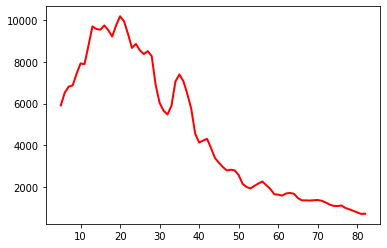

In [14]:
newdf['New York'].diff().rolling(rolling_average_duration).mean().plot()

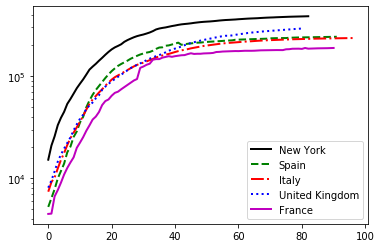

(<matplotlib.axes._subplots.AxesSubplot at 0x12c881b90>,
 <matplotlib.legend.Legend at 0x12cef5e50>)

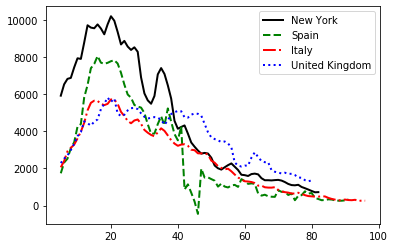

In [15]:
plt.yscale('log')

newdf['New York'].plot(color='k'), newdf_global['Spain'].plot(color='g'), newdf_global['Italy'].plot(),
newdf_global['United Kingdom'].plot(color='b'), newdf_global['France'].plot(color='m'), plt.legend()
plt.show()
daily_us['New York'].plot(color='k'), daily_global['Spain'].plot(color='g'), daily_global['Italy'].plot(),
daily_global['United Kingdom'].plot(color='b'), plt.legend()

In [16]:
#target = ['New York City-New York', 'Los Angeles-California', 'Wayne-Michigan', 'Miami-Dade-Florida']
#targets =  ['Santa Clara-California', 'Los Angeles-California', 'New York City-New York', 'Cook-Illinois', 'Wayne-Michigan', 'Miami-Dade-Florida', 'Middlesex-Massachusetts']
targets = ['Ohio', 'New York', 'Illinois', 'Belgium', 'Switzerland', 'New Jersey', 'France', 'Italy', 'United Kingdom']# 'Ohio', 'Sweden']
#exclude1 = ['Iraq','China-Anhui', 'China-Beijing', 'China-Chongqing', 'China-Guangdong', 'China-Hainan', 'China-Hebei', 'China-Heilongjiang',  'China-Shandong', 'Diamond Princess']
#exclude2=['Iran', 'Italy','France', 'Spain',  'Germany', 'United Kingdom']
#for i in [0,15]:
trial = pd.concat([daily_global, daily_us], axis=1)
singVals =3
#trial = pd.concat([newdf, newdf_global], axis=1)
    
for target in targets:
    sizes = trial[[target]].apply(pd.Series.last_valid_index)
    #print(sizes)
    length = sizes.loc[target]
    #print(length)
    synth_control_predictions2(trial,38,21, "Cases Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=matching+matching_us, svdSpectrum=False)
    
    synth_control_predictions2(trial,38,21, "Cases Data", singVals, ylimit=[], savePlots=False, do_only=[target+" minus 7"], showstates=10,
                               exclude=matching+matching_us+[target])
   


NameError: name 'synth_control_predictions2' is not defined

In [ ]:
#target = ['New York City-New York', 'Los Angeles-California', 'Wayne-Michigan', 'Miami-Dade-Florida']
targets =  ['United Kingdom']#'Italy', 'France', 'United Kingdom', 'New York', 'Spain', 'Switzerland']#'New Jersey', 'Ohio', 'Florida', 'Michigan', 'California']
#targets = ['Switzerland', 'Belgium']# 'Netherlands']# 'Ohio', 'Sweden']
exclude1 = ['Iran', 'Iraq','China-Anhui', 'China-Beijing', 'China-Chongqing', 'China-Guangdong', 'China-Henan', 'China-Hainan', 'China-Hebei', 'China-Heilongjiang',  'China-Shandong', 'Diamond Princess', 'US']
exclude2=['Iran', 'Italy','France', 'Spain',  'Germany', 'United Kingdom']
#trial = pd.concat([daily_global, daily_uscountines], axis=1)
trial = pd.concat([daily_global, daily_us], axis=1)

#fig = plt.figure(figsize=(16,6))
#camera = Camera(fig)
singVals =2  

   

for target in targets:
    fig = plt.figure(figsize=(16,6))
    camera = Camera(fig)
    for i in range(1,20):
        synth_control_predictions2(trial,38,21, "COVID cases", singVals, ylimit=[], savePlots=False, do_only=[target+" minus %s"%i], showstates=12,
                                   exclude=matching+matching_us, animation=camera)
animation = camera.animate()

HTML(animation.to_html5_video())

    #animation.save('../animations/'+target+" no donors shown"'.mp4')
